**BÀI THỰC HÀNH 1 - PHÂN LỚP VĂN BẢN VỚI NAIVE BAYES VÀ LOGISTICREGRESSION**

NỘI DUNG:

*   CHUẨN BỊ NƠI LƯU TRỮ VÀ DỮ LIỆU
*   SỬ DỤNG THƯ VIỆN
*   CÀI ĐẶT THỦ CÔNG


**1) CHUẨN BỊ NƠI LƯU TRỮ VÀ DỮ LIỆU**

Chúng ta sẽ dùng Google Drive để lưu trữ dữ liệu và những kết quả cần thiết. Google Drive được ánh xạ vào đường dẫn /content/C/MyDrive.

Sau đó, chúng ta cần upgrade kagglehub và scikit-learn để sử dụng phiên bản mới nhất.

Tiếp theo, chúng ta sẽ tạo thư mục NLP trên Google Drive.

Sau đó, chuyển đến thư mục vừa được tạo bằng lệnh
cd của linux

Tiếp theo, chúng ta sẽ download dữ liệu SMS Spam từ kaggle. Và lưu file spam.csv vào thư mục NLP trên Google Drive

In [1]:
import shutil
import os

src = os.path.expanduser("~/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1/spam.csv")
dst = os.path.join(os.getcwd(), "spam.csv")
shutil.copy(src, dst)

'c:\\Users\\windown\\PycharmProjects\\helloWorld\\NLP_Practice\\spam.csv'

**2) SỬ DỤNG THƯ VIỆN**

Chúng ta sẽ sử dụng lớp MultiNomialNB, BernoulliNB và LogisticRegression của thư viện Scikit-Learn, đồng thời sử dụng các lớp tiền xử lý dữ liệu của thư viện NLTK, hiển thị biểu đồ với MathPlotLib, và tính các chỉ số đánh giá với thư viện Scikit-Learn.

Chúng ta cũng download các file dữ liệu của NLTK khi cần, gồm "punk_tab" và "stopwords".

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics

import seaborn as sns #Charts

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\windown\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\windown\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Tiếp theo, chúng ta sẽ đọc ngữ liệu SMS Spam bằng cách dùng thư viện Pandas. Sau đó đổi tên cột để thuận tiện cho việc xử lý sau này.

In [3]:
dataset = pd.read_csv("spam.csv", encoding="windows-1252")
dataset.info()
dataset = dataset.drop(dataset[["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]], axis=1)
dataset.rename(columns = {"v1":"Class", "v2":"Message"}, inplace = True)
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Khi có được ngữ liệu, chúng ta cần thống kê để nắm thông tin sơ bộ về ngữ liệu. Một trong những thống kê quan trọng, là số lượng mẫu, hay data point của mỗi lớp.

Text(0, 0.5, 'Số mẫu')

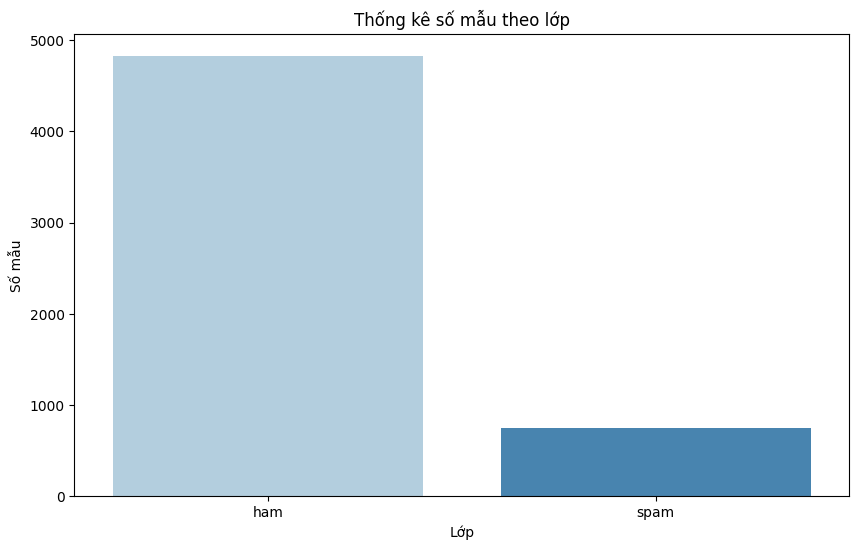

In [4]:
cols= sns.color_palette("Blues", n_colors=2)

plt.figure(figsize=(10,6))
fig = sns.countplot(data=dataset, x='Class', hue="Class", palette= cols, legend=False)
fig.set_title("Thống kê số mẫu theo lớp", color="#000000")
fig.set_xlabel("Lớp")
fig.set_ylabel("Số mẫu")

Tiếp theo, là tiền xử lý dữ liệu, ở đây là các SMS. Chúng ta sẽ thực hiện:

- Loại bỏ các ký tự không phải bộ chữ cái.
- Chuyển thành chữ thường
- Loại bỏ khoảng trắng thừa.

(Các bạn có thể tiền xử lý với những bước xử lý khác, phù hợp với bài toán)

In [5]:
def Preprocess(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

dataset["PrepMessage"] = dataset["Message"].apply(Preprocess)
#Lets have a look at a sample of texts after cleaning
print(*dataset["PrepMessage"][:5], sep = "\n")

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


Sau đó, chúng ta sẽ thực hiện vector hóa các SMS của bộ ngữ liệu, thành một tập các vectors. Trong phần này, chúng ta dùng lớp TfidfVectorizer. Tuy nhiên, đến phần thực hành của các bạn, các bạn cần thực hiện thủ công theo ý tưởng của mình.

Cùng với việc vector hóa nội dung SMS, chúng ta cũng mã hóa các giá trị lớp tương ứng với các SMS, thành những giá trị số với lớp LabelEncoder.

In [6]:
corpus = list(dataset["PrepMessage"])
tfidf = TfidfVectorizer()
vectors = tfidf.fit_transform(corpus).toarray()

print(vectors.shape)
label_encoder = LabelEncoder()
dataset["Class"] = label_encoder.fit_transform(dataset["Class"])
print(dataset["Class"][:5])

(5572, 7682)
0    0
1    0
2    1
3    0
4    0
Name: Class, dtype: int32


Chúng ta bắt đầu chia dữ liệu thành các tập Train và Test. Trong đó, kích thước tập Train bằng 80% kích thước tập mẫu, và kích thước tập Test bằng 20% kích thước tập mẫu. Tập Train gồm Trainvecs chứa các vector đầu vào và Trainclss chứa các nhãn tương ứng. Tập Test gồm Testvecs chứa các vector đầu vào và Testclss chứa các nhãn tương ứng.

In [7]:
classes = dataset["Class"]

Trainvecs, Testvecs, Trainclss, Testclss = train_test_split(vectors, classes, test_size=0.2, random_state=42)

Tiếp theo, chúng ta thử nghiệm hiệu quả của bộ phân lớp Multinomial Naive Bayes, bằng cách sử dụng lớp MultinomialNB của thư viện Scikit-Learn.
Chúng ta tính cross validate score cho f1, với k-fold là 10. Sau đó tính Precision, Recall, F1, Accuracy trên tập Train và Accuracy trên tập Test. Cuối cùng, trình bày confusion matrix.

0.803343768589805
Precision: 0.9901960784313726, Recall: 0.6733333333333333, F1: 0.8015873015873016, Train Accuracy: 0.9683643706529056, Test Accuracy: 0.9551569506726457


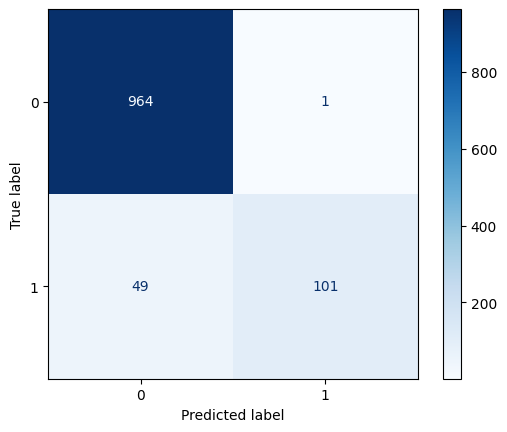

In [8]:
cls = MultinomialNB()
cls.fit(Trainvecs, Trainclss)
cv_score = cross_val_score(cls, Trainvecs, Trainclss, scoring="f1", cv=10)
print(cv_score.mean())
pred_train = cls.predict(Trainvecs)
pred_test = cls.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = cls.score(Trainvecs, Trainclss)
test_accuracy = cls.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
ConfusionMatrixDisplay.from_estimator(cls, Testvecs, Testclss, cmap="Blues")

Tiếp theo, chúng ta thử nghiệm hiệu quả của bộ phân lớp Bernoulli Naive Bayes, bằng cách sử dụng lớp Bernoulli NB của thư viện Scikit-Learn.
Chúng ta cũng tính cross validate score cho f1, với k-fold là 10. Sau đó tính Precision, Recall, F1, Accuracy trên tập Train và Accuracy trên tập Test. Cuối cùng, trình bày confusion matrix.

0.9112250574062809
Precision: 0.9689922480620154, Recall: 0.8333333333333334, F1: 0.8960573476702509, Train Accuracy: 0.9867623962306484, Test Accuracy: 0.9739910313901345


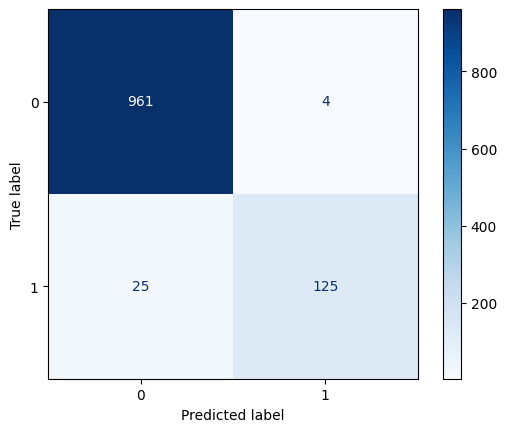

In [9]:
cls = BernoulliNB()
cls.fit(Trainvecs, Trainclss)
cv_score = cross_val_score(cls, Trainvecs, Trainclss, scoring="f1", cv=10)
print(cv_score.mean())
pred_train = cls.predict(Trainvecs)
pred_test = cls.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = cls.score(Trainvecs, Trainclss)
test_accuracy = cls.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
ConfusionMatrixDisplay.from_estimator(cls, Testvecs, Testclss, cmap="Blues")

Tiếp theo, chúng ta thử nghiệm hiệu quả của bộ phân lớp Logistic Regression, bằng cách sử dụng lớp LogisticRegression của thư viện Scikit-Learn.
Chúng ta cũng tính cross validate score cho f1, với k-fold là 10. Sau đó tính Precision, Recall, F1, Accuracy trên tập Train và Accuracy trên tập Test. Cuối cùng, trình bày confusion matrix.

0.8363898388026101
Precision: 1.0, Recall: 0.7333333333333333, F1: 0.8461538461538461, Train Accuracy: 0.9764415526138658, Test Accuracy: 0.9641255605381166


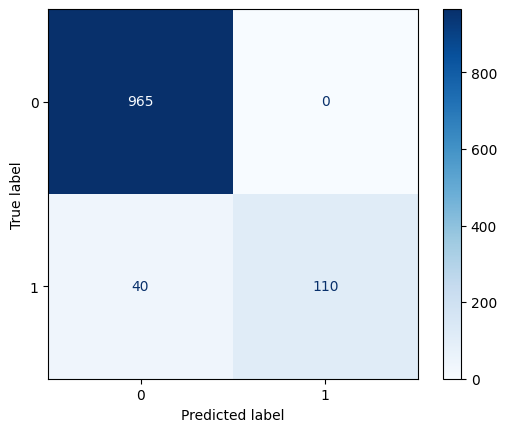

In [10]:
cls = LogisticRegression()
cls.fit(Trainvecs, Trainclss)
cv_score = cross_val_score(cls, Trainvecs, Trainclss, scoring="f1", cv=10)
print(cv_score.mean())
pred_train = cls.predict(Trainvecs)
pred_test = cls.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = cls.score(Trainvecs, Trainclss)
test_accuracy = cls.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
ConfusionMatrixDisplay.from_estimator(cls, Testvecs, Testclss, cmap="Blues")

**3) CÀI ĐẶT THỦ CÔNG**

Phần này, các bạn sẽ tự huấn luyện các mô hình Multinomial Naive Bayes, Bernoulli Naive Bayes và Logistic Regression trên tập Train và đánh giá trên tập Test đã dùng ở trên.

Đầu tiên, các bạn tham khảo đoạn chương trình nhỏ, huấn luyện mô hình Logistic Regression có đầu vào là một biến x và đầu ra là một biến y. Sau đó, các bạn có thể mở rộng để áp dụng cho bài toán SMS Spam Detection.

In [11]:
X = [-3, -2, -1, 1, 2, 3]
Y = [0, 0, 0, 1, 1, 1]

def Logistic(x):
  return 1/(1+np.exp(-x))

def Forward(x, w, b):
  z = np.dot(w, x) + b
  return Logistic(z)

W = np.array([1])
B = 1
WW = np.array([1])
BB = 1
lr = 0.5
l2 = 0.05
epoch = 50
for i in range(epoch):
  for j in range(len(X)):
    d = (Y[j] - Forward(X[j], W, B))
    W = W + (X[j] * d - l2 * W) * lr
    B = B + (d - l2*B) * lr

    dd = (Y[j] - Forward(X[j], WW, BB))
    WW = WW + (X[j] * dd) * lr
    BB = BB + dd * lr
print(W, B)
print(WW, BB)

[1.67509653] [0.02211244]
[4.08029638] [0.08614365]


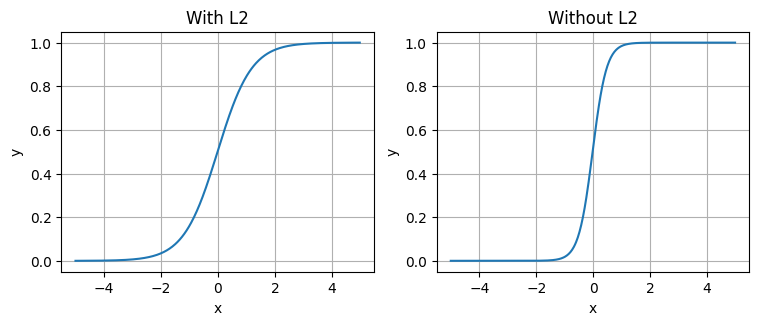

In [12]:
Xp = [x / 50 for x in range(-250, 250)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(bottom=0, right=1.2, top=0.5)
ax1.plot(Xp, [Forward(x, W, B) for x in Xp])
ax1.set_title('With L2')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)
ax2.plot(Xp, [Forward(x, WW, BB) for x in Xp])
ax2.set_title('Without L2')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True)

Tiếp theo, các bạn sẽ cài đặt các lớp hoặc các hàm cần thiết để huấn luyện các mô hình Multinomial Naive Bayes, Bernoulli Naive Bayes và Logistic Regression.

Đầu tiên là

**Multinomial Naive Bayes** và kết quả thử nghiệm để so sánh với mô hình dùng thư viện.

# Công thức liên quan đến MultinomialNB

* Gọi $P(c)$ là xác suất tiên nghiệm của lớp c
* Gọi $P(x_i \mid c)$ là xác suất của đặc trưng $x_i$ khi biết lớp c
* $x = (x_1, x_2,..., x_n)$ là vector đặc trưng 

* Hàm dự đoán:
$$\hat{y} = \text{arg max}_c (\log P(c) + \sum_{i=1}^n x_i \log P(x_i \mid c))$$

In [13]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.class_log_prior = None # Xac suat tien nghiem
        self.feature_log_prob = None # Xac suat cho cac dac trung
        self.classes_ = None
    
    def fit(self, X, y):
        # X: (n_samples, n_features), y: (n_samples,)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_log_prior = np.zeros(n_classes)
        self.feature_log_prob = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            class_count = X_c.shape[0]
            self.class_log_prior = np.log(class_count / n_samples)

            feature_count = X_c.sum(axis=0) + self.alpha
            feature_prob = feature_count / feature_count.sum()
            self.feature_log_prob[idx] = np.log(feature_prob)

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])
    
    def _predict_one(self, X):
        # log(P(c)) + sum(x_i * log(P(x_i|c)))
        log_probs = self.class_log_prior + (X * self.feature_log_prob).sum(axis=1)
        return self.classes_[np.argmax(log_probs)]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
model = MultinomialNaiveBayes(alpha=1.0)
model.fit(Trainvecs, Trainclss)
pred_train = model.predict(Trainvecs)
pred_test = model.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = model.score(Trainvecs, Trainclss)
test_accuracy = model.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
print(confusion_matrix(Testclss, pred_test))

Precision: 0.7964071856287425, Recall: 0.8866666666666667, F1: 0.8391167192429022, Train Accuracy: 0.9827238052501682, Test Accuracy: 0.9542600896860987
[[931  34]
 [ 17 133]]


Tiếp theo là

**Bernoulli Naive Bayes** và kết quả thử nghiệm để so sánh với mô hình dùng thư viện.

# Công thức liên quan đến BernoulliNB

Với mỗi lớp c, ta tính:
$$\hat{y} = \text{arg max}_c (\log P(c) + \sum_{i=1}^n [x_i \cdot \log P(x_i = 1 \mid c) + (1 - x_i) \cdot \log P(x_i = 0 \mid c) ])$$

In [16]:
class BernoulliNaiveBayes:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.class_log_prior = None
        self.feature_log_prob = None    # log P(x=1|c)
        self.feature_log_prob_neg = None # log P(x=0|c)
        self.classes_ = None
    
    def binarize(self, X):
        return (X > 0).astype(int)
    
    def fit(self, X, y):
        X = self.binarize(X)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_log_prior = np.zeros(n_classes)
        self.feature_log_prob = np.zeros((n_classes, n_features))
        self.feature_log_prob_neg = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            class_count = X_c.shape[0]
            self.class_log_prior[idx] = np.log(class_count / n_samples)

            # Số mẫu trong lớp c có đặc trưng i = 1
            feature_count = X_c.sum(axis=0)
            smoothed = (feature_count + self.alpha) / (class_count + 2 * self.alpha)
            self.feature_log_prob[idx] = np.log(smoothed)
            self.feature_log_prob_neg[idx] = np.log(1 - smoothed)

    def _predict_one(self, X):
        # log P(c) + sum x_i * log P(x = 1|c) + (1 - x_i) * log P(x = 0|c)
        log_probs = self.class_log_prior + \
                    (X * self.feature_log_prob + (1-X) * self.feature_log_prob_neg).sum(axis=1)
        return self.classes_[np.argmax(log_probs)]
    
    def predict(self, X):
        X = self.binarize(X)
        return np.array([self._predict_one(x) for x in X])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [17]:
model = BernoulliNaiveBayes(alpha=1.0)
model.fit(Trainvecs, Trainclss)
pred_train = model.predict(Trainvecs)
pred_test = model.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = model.score(Trainvecs, Trainclss)
test_accuracy = model.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
print(confusion_matrix(Testclss, pred_test))

Precision: 0.9689922480620154, Recall: 0.8333333333333334, F1: 0.8960573476702509, Train Accuracy: 0.9867623962306484, Test Accuracy: 0.9739910313901345
[[961   4]
 [ 25 125]]


Cuối cùng là

**Logistic Regression** và kết quả thử nghiệm để so sánh với mô hình dùng thư viện.

# Công thức liên quan đến Logistic Regression

* Dự đoán xác suất:

$$\hat{y} = \sigma (w^Tx + b) = \frac{1}{1 + e^-{w^Tx + b}}$$

* Hàm Loss - Binary Cross Entropy

$$\mathcal{L} = -\frac{1}{n} \sum_{i=1}^n [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_1)]$$

* Huấn luyện bằng gradient cập nhật w và b

In [20]:
class LR:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        pos_weights = n_samples / (2 * np.sum(y))
        neg_weights = n_samples / (2 * (n_samples - np.sum(y)))

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(linear_model)

            weights = np.where(y == 1, pos_weights, neg_weights)

            dw = (1 / n_samples) * np.dot(X.T, weights * (y_pred - y))
            db = (1 / n_samples) * np.sum(weights * (y_pred - y))

            self.w -= self.lr * dw
            self.b -= self.lr * db
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.w) + self.b
        return self.sigmoid(linear_model)
    
    def predict(self, X):
        y_probs = self.predict_proba(X)
        return np.where(y_probs >= 0.5, 1, 0)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [21]:
model = LR()
model.fit(Trainvecs, Trainclss)
pred_train = model.predict(Trainvecs)
pred_test = model.predict(Testvecs)
prec = metrics.precision_score(Testclss, pred_test)
recal = metrics.recall_score(Testclss, pred_test)
f1_s = metrics.f1_score(Testclss, pred_test)
train_accuracy = model.score(Trainvecs, Trainclss)
test_accuracy = model.score(Testvecs, Testclss)
print("Precision: {}, Recall: {}, F1: {}, Train Accuracy: {}, Test Accuracy: {}".format(prec, recal, f1_s, train_accuracy, test_accuracy))
print(confusion_matrix(Testclss, pred_test))

Precision: 0.8057142857142857, Recall: 0.94, F1: 0.8676923076923077, Train Accuracy: 0.962979582678932, Test Accuracy: 0.9614349775784753
[[931  34]
 [  9 141]]
